In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import yfinance as yf
from sklearn.cluster import KMeans

import seaborn as sns
sns.set(style='darkgrid')
import plotly.graph_objects as go

import sys
sys.path.append('../src') 

from scipy.stats import norm
from scipy.optimize import minimize

In [2]:
from kneed import KneeLocator

def get_optimum_clusters(df, saturation_point=0.05):
    '''

    :param df: dataframe
    :param saturation_point: The amount of difference we are willing to detect
    :return: clusters with optimum K centers

    This method uses elbow method to find the optimum number of K clusters
    We initialize different K-means with 1..10 centers and compare the inertias
    If the difference is no more than saturation_point, we choose that as K and move on
    '''

    wcss = []
    k_models = []

    size = min(11, len(df.index))
    for i in range(1, size):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        k_models.append(kmeans)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    # knee = KneeLocator(range(1, size), wcss, curve='convex', direction='decreasing')
    # optimum_k = knee.knee

    optimum_clusters = k_models[optimum_k]

    return optimum_clusters

def identify_weak_support_resistance(data):
    # Initialize an empty list to store the labels (support, resistance, neither)
    labels = []

    # Iterate through the dataframe to identify weak support and weak resistance
    for i in range(len(data)):
        if i == 0 or i == len(data) - 1:
            # Edge cases where there's no previous or following day
            labels.append("neither")
        elif data['close'][i] < data['close'][i - 1] and data['close'][i] < data['close'][i + 1]:
            # Weak support condition
            labels.append("weak support")
        elif data['close'][i] > data['close'][i - 1] and data['close'][i] > data['close'][i + 1]:
            # Weak resistance condition
            labels.append("weak resistance")
        else:
            # Neither weak support nor weak resistance
            labels.append("neither")

    # Add the labels to a new column in the dataframe
    data['Support/Resistance'] = labels

    return data

In [3]:
def plot_stock(stock_name,
               start=(datetime.today() - relativedelta(years=2)).strftime('%Y-%m-%d'),
               end=datetime.today(),
               figsize=(12, 6),
               interactive=False,
               return_result=False,
              ):
    '''
    Input:
    stock_name: str
    start: datetime
    end: datetime
    '''
    df = yf.download(stock_name.upper(),
                     start=start,
                     end=end)
    df = df.reset_index()
    df.columns = df.columns.str.lower()

    df['20 Day MA'] = df['close'].rolling(window=20).mean()
    df['20 Day STD'] = df['close'].rolling(window=20).std()
    
    # Calculate upper and lower bands
    df['Upper Band'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
    close = df.iloc[-1]['close']
    print('* previous stock price closing', round(close,2))
    print("Latest 20 Day MA:", df['20 Day MA'].tolist()[-1])
    print("Latest Lower Bollinger Band:", df['Lower Band'].tolist()[-1])
    print("Latest Higher Bollinger Band:", df['Upper Band'].tolist()[-1])

    # df = identify_weak_support_resistance(df)
    
    # low_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak support'][['date',"close"]].set_index('date'))
    # low_centers = low_clusters.cluster_centers_
    # low_centers = np.sort(low_centers, axis=0)
    
    # high_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak resistance'][['date',"close"]].set_index('date'))
    # high_centers = high_clusters.cluster_centers_
    # high_centers = np.sort(high_centers, axis=0)
    
    # print('Supports')
    # print([low[0] for low in low_centers[:]])
    # print('Resistance')
    # print([high[0] for high in high_centers[:]])
    if interactive:
        fig = go.Figure(layout=dict(width=figsize[0]*80, height=figsize[1]*80))
        
        fig.add_trace(go.Scatter(x=df['date'], y=df['close'], name='Daily Price'))
        fig.add_trace(go.Scatter(x=df['date'], y=df['20 Day MA'], mode='lines', line=dict(dash='dash'), name='20 Day MA'))
        fig.add_trace(go.Scatter(x=df['date'], y=df['Lower Band'], mode='lines', line=dict(dash='dash'), name='Lower Band'))
        fig.add_trace(go.Scatter(x=df['date'], y=df['Upper Band'], mode='lines', line=dict(dash='dash'), name='Upper Band', fill='tonexty', fillcolor='rgba(128,128,128,0.3)'))
        
        # for low in low_centers[:]:
        #     fig.add_trace(go.Scatter(x=df['date'], y=[low[0]]*len(df['date']), mode='lines', line=dict(color='green', dash='dash'), name='Support at ' + str(low[0])))
        # for high in high_centers[:]:
        #     fig.add_trace(go.Scatter(x=df['date'], y=[high[0]]*len(df['date']), mode='lines', line=dict(color='red', dash='dash'), name='Resistance at ' + str(high[0])))        
        fig.update_layout(title='Interactive Plot of Daily Stock Price for ' + stock_name,
                          xaxis_title='date',
                          yaxis_title='Daily Price',
                          hovermode='closest')
        
        # Add ability to select a single data point
        fig.update_traces(marker=dict(size=10, opacity=0.8),
                          selector=dict(mode='markers'))
        
        fig.show()
    else:
        fig, ax = plt.subplots(figsize=figsize)
        ax.grid(True, alpha=0.5)
    
        ax.plot(df['date'], df['close'], label='Daily Close Price')
        ax.plot(df['date'], df['20 Day MA'], ls='--', label='20 Day Moving Average')
        ax.plot(df['date'], df['Upper Band'], ls='--', label='Upper Bollinger Band')
        ax.plot(df['date'], df['Lower Band'], ls='--', label='Lower Bollinger Band')
        ax.fill_between(df['date'], df['Upper Band'], df['Lower Band'], color='gray', alpha=0.3) # Fill the area between the bands
    
        ax.set_title('Daily stock price for ' + stock_name)
        ax.legend()
        
        # for low in low_centers[:]:
    	   #  ax.axhline(low[0], color='green', ls='--')
        # for high in high_centers[:]:
    	   #  ax.axhline(high[0], color='red', ls='--')

    if return_result:
        return df

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 471.58
Latest 20 Day MA: 476.51425018310545
Latest Lower Bollinger Band: 469.8092071482229
Latest Higher Bollinger Band: 483.21929321798797


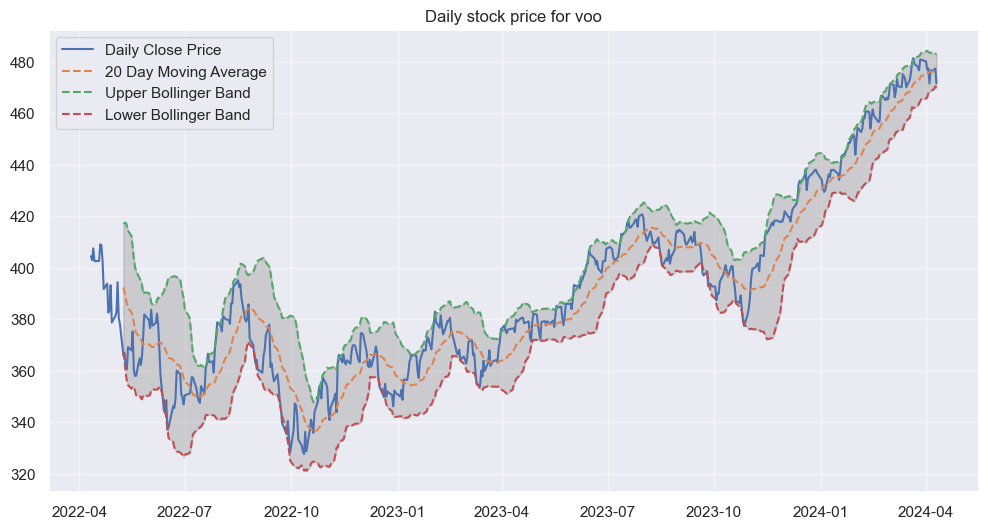

In [4]:
plot_stock('voo')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 471.58
Latest 20 Day MA: 476.51425018310545
Latest Lower Bollinger Band: 469.8092071482229
Latest Higher Bollinger Band: 483.21929321798797


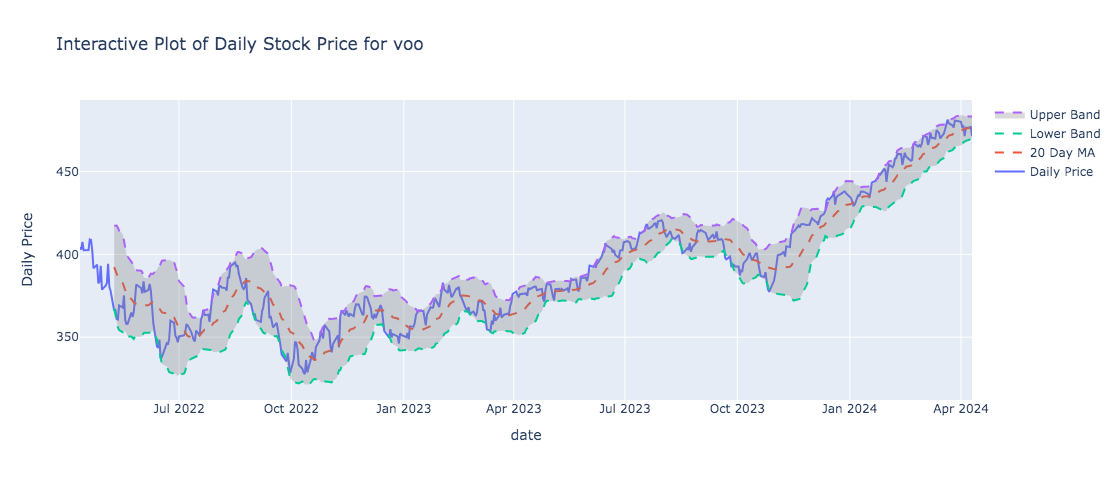

In [5]:
plot_stock('voo', interactive=True)

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 180.03
Latest 20 Day MA: 181.60199966430665
Latest Lower Bollinger Band: 178.73602728105638
Latest Higher Bollinger Band: 184.4679720475569


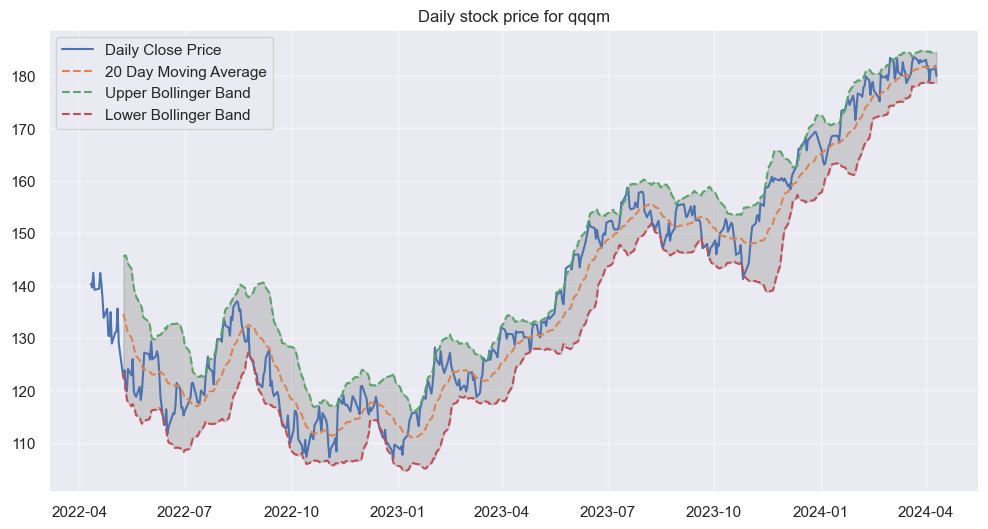

In [6]:
plot_stock('qqqm')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 414.69
Latest 20 Day MA: 413.62650299072266
Latest Lower Bollinger Band: 403.8982277121938
Latest Higher Bollinger Band: 423.35477826925154


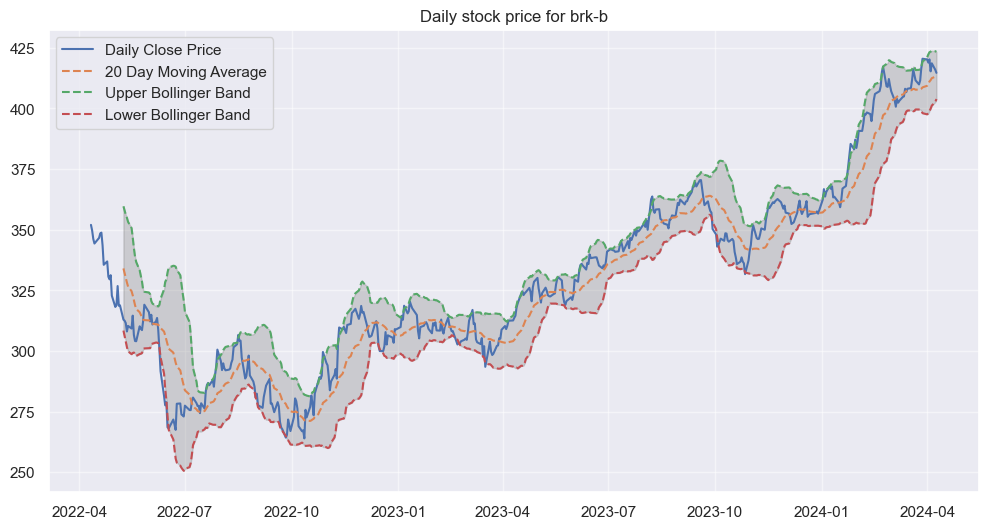

In [7]:
plot_stock('brk-b')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 417.36
Latest 20 Day MA: 427.1802505493164
Latest Lower Bollinger Band: 411.0237603701969
Latest Higher Bollinger Band: 443.33674072843587


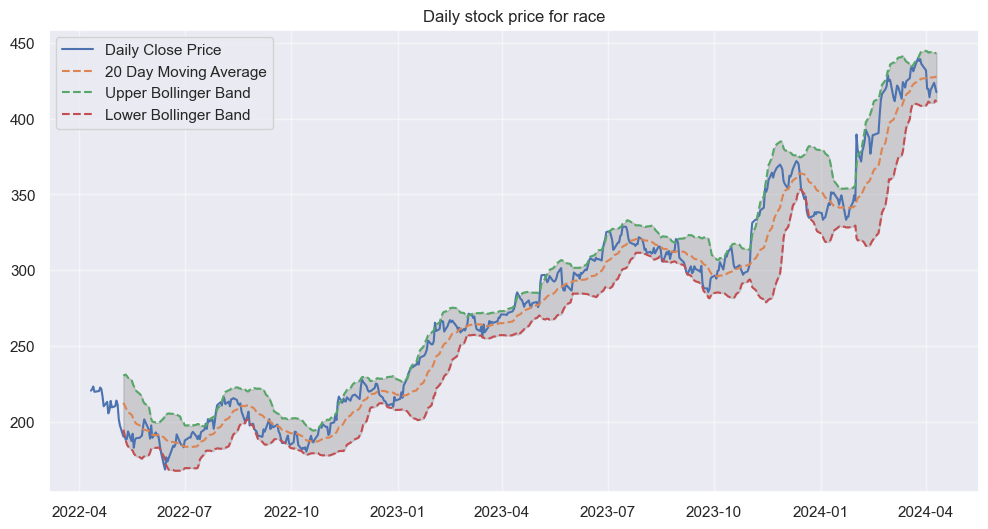

In [8]:
plot_stock('race')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 169.67
Latest 20 Day MA: 171.62449951171874
Latest Lower Bollinger Band: 166.4467038530476
Latest Higher Bollinger Band: 176.80229517038987


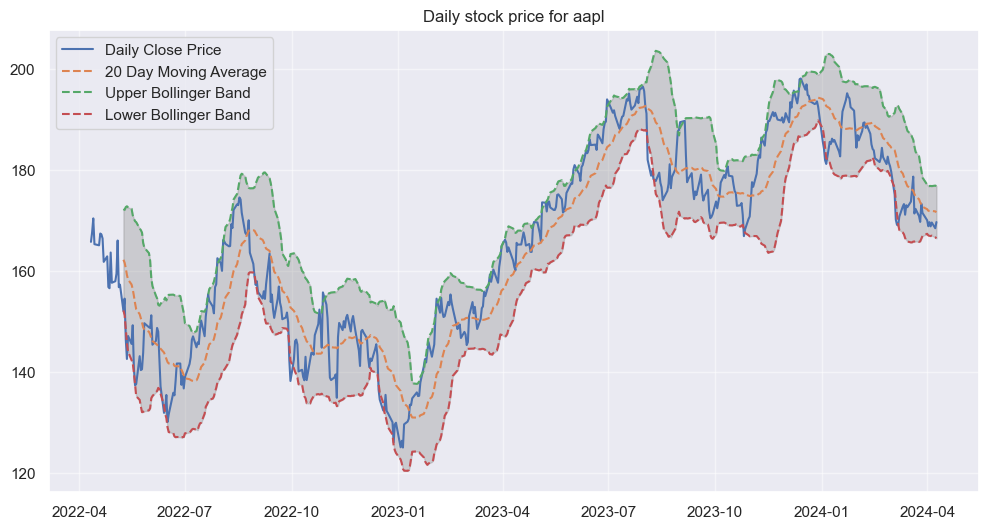

In [9]:
plot_stock('aapl')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 459.72
Latest 20 Day MA: 480.69700317382814
Latest Lower Bollinger Band: 449.0886863585689
Latest Higher Bollinger Band: 512.3053199890874


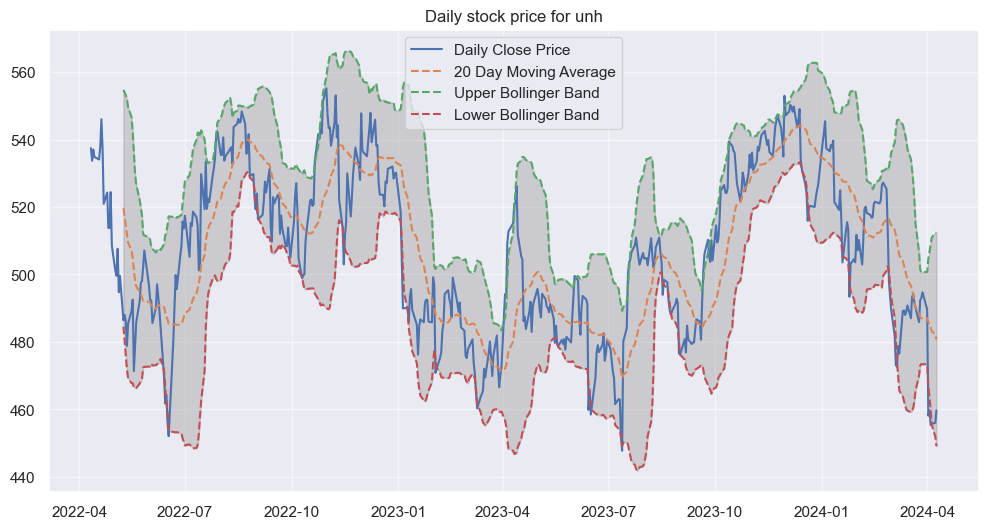

In [10]:
plot_stock('unh')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 709.34
Latest 20 Day MA: 724.8394989013672
Latest Lower Bollinger Band: 701.3304998998683
Latest Higher Bollinger Band: 748.348497902866


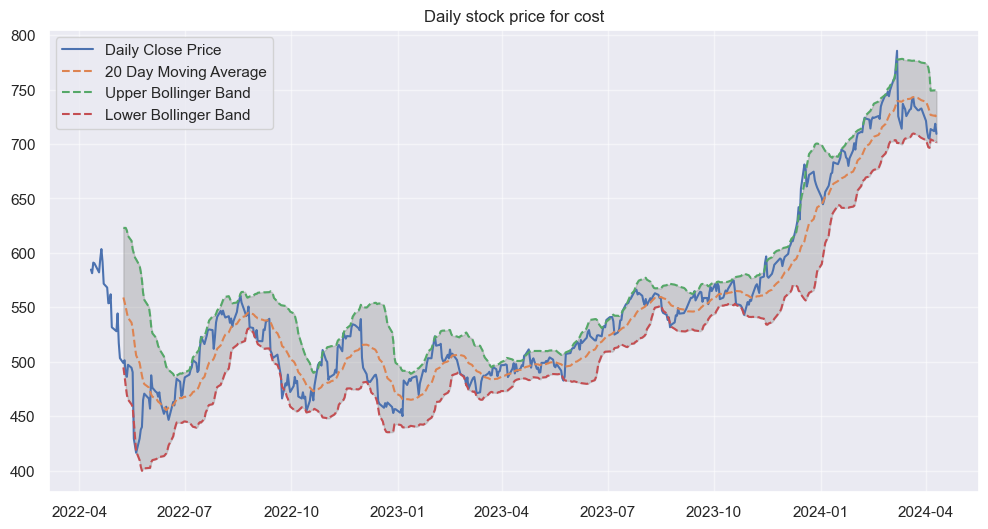

In [11]:
plot_stock('cost')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 358.8
Latest 20 Day MA: 413.4904983520508
Latest Lower Bollinger Band: 319.55145447922126
Latest Higher Bollinger Band: 507.4295422248803


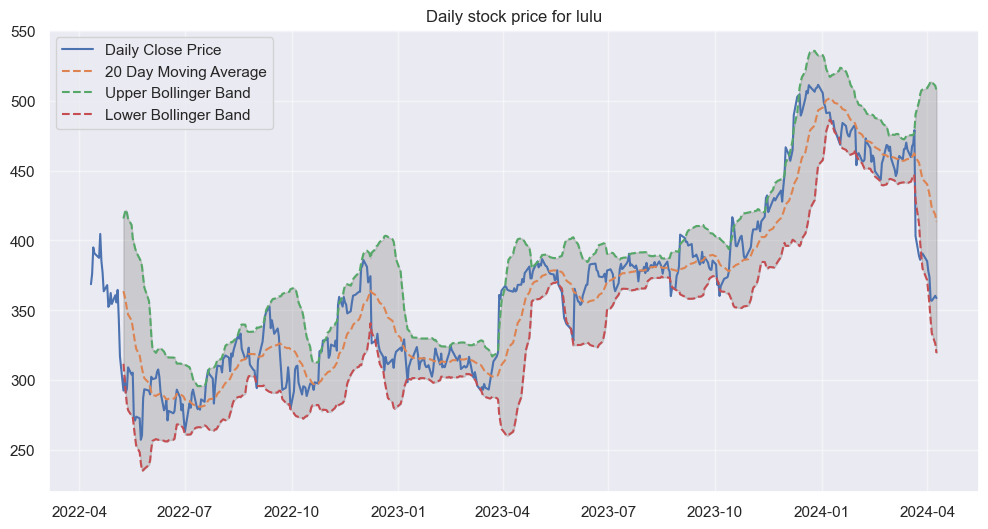

In [12]:
plot_stock('lulu')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 138.65
Latest 20 Day MA: 141.71575164794922
Latest Lower Bollinger Band: 135.14365059947994
Latest Higher Bollinger Band: 148.2878526964185


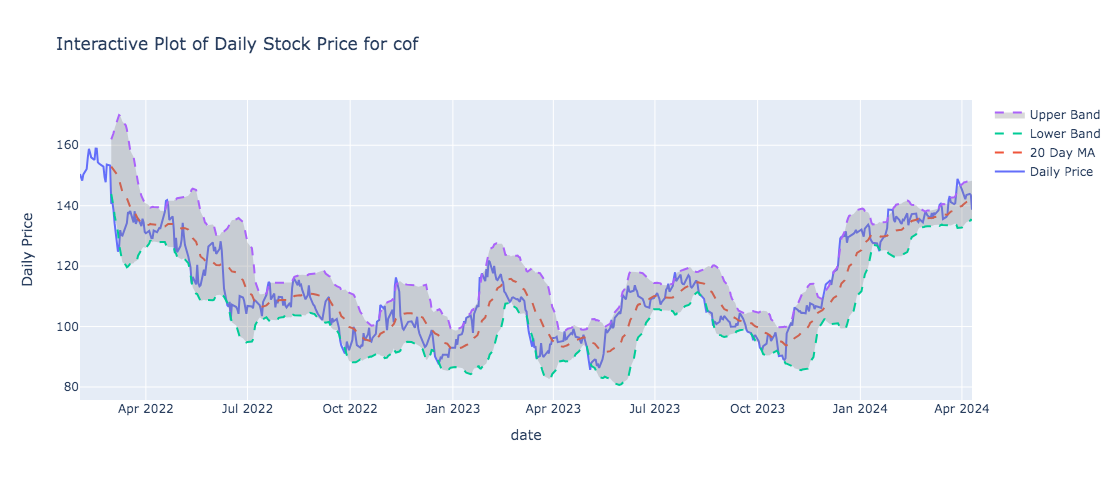

0.06181818181818182


In [13]:
df_cof = plot_stock('cof', start="2022-02-01", return_result=True, interactive=True)
print(df_cof[df_cof['close']>=df_cof['Upper Band']].shape[0] / df_cof.shape[0])

In [14]:
df_brk = yf.download('brk-b'.upper(),
                 start='1996-05-10',
                 end=datetime.today())
df_brk = df_brk.reset_index()
df_brk['log_price'] = np.log(df_brk['Close'])

df_brk.head()

[*********************100%%**********************]  1 of 1 completed


Date  Open       High        Low      Close  Adj Close   Volume  \
0 1996-05-10  24.0  24.200001  23.600000  24.000000  24.000000  1060000   
1 1996-05-13  24.0  24.100000  23.299999  23.900000  23.900000   700000   
2 1996-05-14  24.0  24.100000  23.100000  23.600000  23.600000   310000   
3 1996-05-15  23.6  23.700001  23.000000  23.200001  23.200001   545000   
4 1996-05-16  23.1  23.100000  22.299999  22.600000  22.600000   360000   

   log_price  
0   3.178054  
1   3.173878  
2   3.161247  
3   3.144152  
4   3.117950

[1.42062762] [0.00010474]
Final price extracted: [308.06006674]


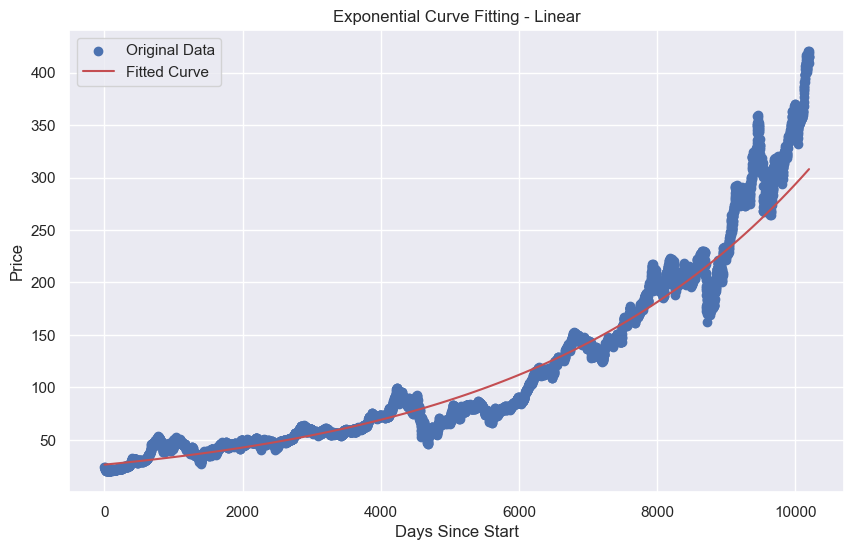

In [15]:
df_sub = df_brk.reset_index()
df_sub['days_since_start'] = (df_sub['Date'] - df_sub['Date'].min()).dt.days

X = df_sub['days_since_start'].values.reshape(-1, 1)  # Feature matrix (date)
y = np.log10(df_sub['Close']).values.reshape(-1, 1)         # Target vector (price)

X_b = np.c_[np.ones((len(X), 1)), X]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

intercept, slope = theta_best[0], theta_best[1]

print(intercept, slope)
print('Final price extracted:',10**(intercept + slope*df_sub.tail(1)['days_since_start'].unique()[0]))

# Generate the fitted curve
days_range = np.linspace(df_sub['days_since_start'].min(), df_sub['days_since_start'].max(), 100)
fitted_curve = 10**(intercept + slope*days_range)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(df_sub['days_since_start'], df_sub['Close'], label='Original Data')
plt.plot(days_range, fitted_curve, 'r-', label='Fitted Curve')
plt.xlabel('Days Since Start')
plt.ylabel('Price')
plt.title('Exponential Curve Fitting - Linear')
plt.legend()
plt.grid(True)
plt.show()


[2.47699345] [0.00027408]
Final price extracted: [401.69153251]


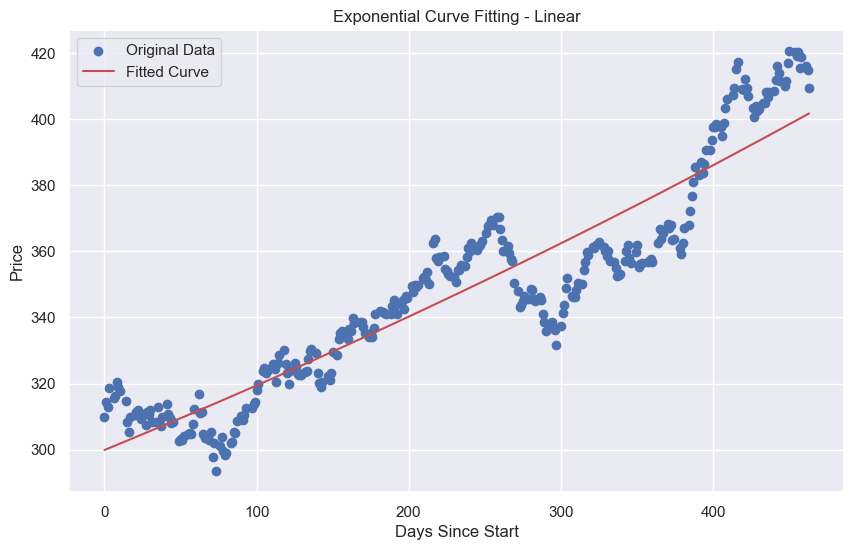

In [16]:
df_sub = df_brk.reset_index()
df_sub = df_sub[df_sub['Date']>=pd.to_datetime('2023-01-01')]

df_sub['days_since_start'] = (df_sub['Date'] - df_sub['Date'].min()).dt.days

X = df_sub['days_since_start'].values.reshape(-1, 1)  # Feature matrix (date)
y = np.log10(df_sub['Close']).values.reshape(-1, 1)         # Target vector (price)

X_b = np.c_[np.ones((len(X), 1)), X]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

intercept, slope = theta_best[0], theta_best[1]

print(intercept, slope)
print('Final price extracted:',10**(intercept + slope*df_sub.tail(1)['days_since_start'].unique()[0]))

# Generate the fitted curve
days_range = np.linspace(df_sub['days_since_start'].min(), df_sub['days_since_start'].max(), 100)
fitted_curve = 10**(intercept + slope*days_range)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(df_sub['days_since_start'], df_sub['Close'], label='Original Data')
plt.plot(days_range, fitted_curve, 'r-', label='Fitted Curve')
plt.xlabel('Days Since Start')
plt.ylabel('Price')
plt.title('Exponential Curve Fitting - Linear')
plt.legend()
plt.grid(True)
plt.show()


19.448273983358714 0.0001236865480808712
Final price extracted: 354.9055532934167


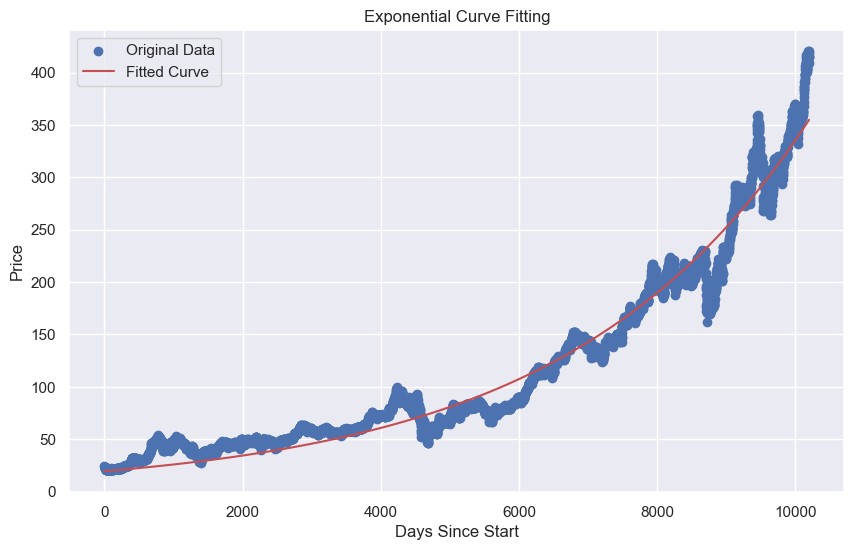

In [17]:
df_sub = df_brk.reset_index()
df_sub['days_since_start'] = (df_sub['Date'] - df_sub['Date'].min()).dt.days

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' and contains columns 'days_since_start' and 'Close'

# Define the exponential function
def exponential_func(x, a, b):
    return a * 10**(b * x)

# Initial guess for parameters
initial_guess = (df_sub.head(1)['Close'].unique()[0], np.log10(df_sub.tail(1)['Close'].unique()[0] / df_sub.head(1)['Close'].unique()[0])/df_sub.tail(1)['days_since_start'].unique()[0])  # You might need to adjust these initial values based on your data

# Fit the curve
popt, pcov = curve_fit(exponential_func, df_sub['days_since_start'], df_sub['Close'], p0=initial_guess)

a_fit, b_fit = popt
print(a_fit, b_fit)
print('Final price extracted:',exponential_func(df_sub.tail(1)['days_since_start'].unique()[0],a_fit, b_fit))

# Generate the fitted curve
days_range = np.linspace(df_sub['days_since_start'].min(), df_sub['days_since_start'].max(), 100)
fitted_curve = exponential_func(days_range, *popt)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(df_sub['days_since_start'], df_sub['Close'], label='Original Data')
plt.plot(days_range, fitted_curve, 'r-', label='Fitted Curve')
plt.xlabel('Days Since Start')
plt.ylabel('Price')
plt.title('Exponential Curve Fitting')
plt.legend()
plt.grid(True)
plt.show()


299.089760187402 0.00027998923465197295
Final price extracted: 403.1220558423505


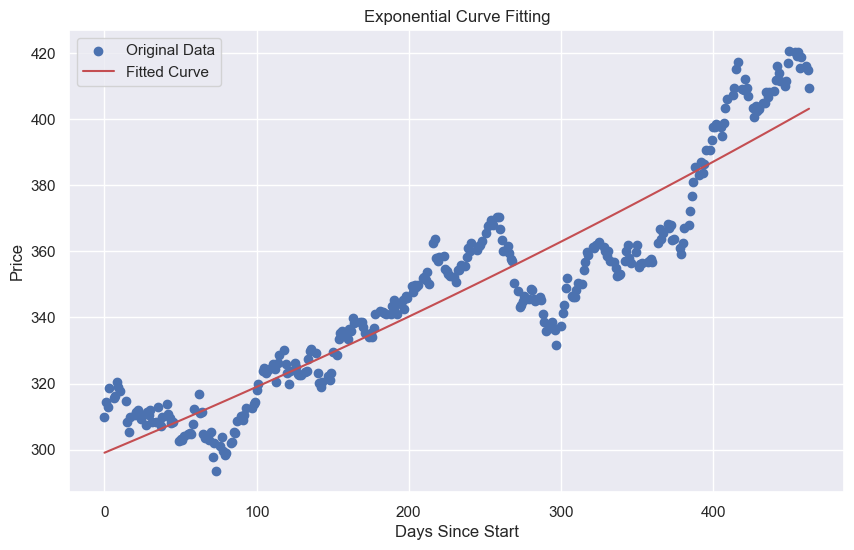

In [19]:
df_sub = df_brk.reset_index()
df_sub = df_sub[df_sub['Date']>=pd.to_datetime('2023-01-01')]
df_sub['days_since_start'] = (df_sub['Date'] - df_sub['Date'].min()).dt.days

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' and contains columns 'days_since_start' and 'Close'

# Define the exponential function
def exponential_func(x, a, b):
    return a * 10**(b * x)

# Initial guess for parameters
initial_guess = (df_sub.head(1)['Close'].unique()[0], np.log10(df_sub.tail(1)['Close'].unique()[0] / df_sub.head(1)['Close'].unique()[0])/df_sub.tail(1)['days_since_start'].unique()[0])  # You might need to adjust these initial values based on your data

# Fit the curve
popt, pcov = curve_fit(exponential_func, df_sub['days_since_start'], df_sub['Close'], p0=initial_guess)

a_fit, b_fit = popt
print(a_fit, b_fit)
print('Final price extracted:',exponential_func(df_sub.tail(1)['days_since_start'].unique()[0],a_fit, b_fit))

# Generate the fitted curve
days_range = np.linspace(df_sub['days_since_start'].min(), df_sub['days_since_start'].max(), 100)
fitted_curve = exponential_func(days_range, *popt)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(df_sub['days_since_start'], df_sub['Close'], label='Original Data')
plt.plot(days_range, fitted_curve, 'r-', label='Fitted Curve')
plt.xlabel('Days Since Start')
plt.ylabel('Price')
plt.title('Exponential Curve Fitting')
plt.legend()
plt.grid(True)
plt.show()


315.9351214486484 0.0002866472253847749
Final price extracted: 404.12649359986136


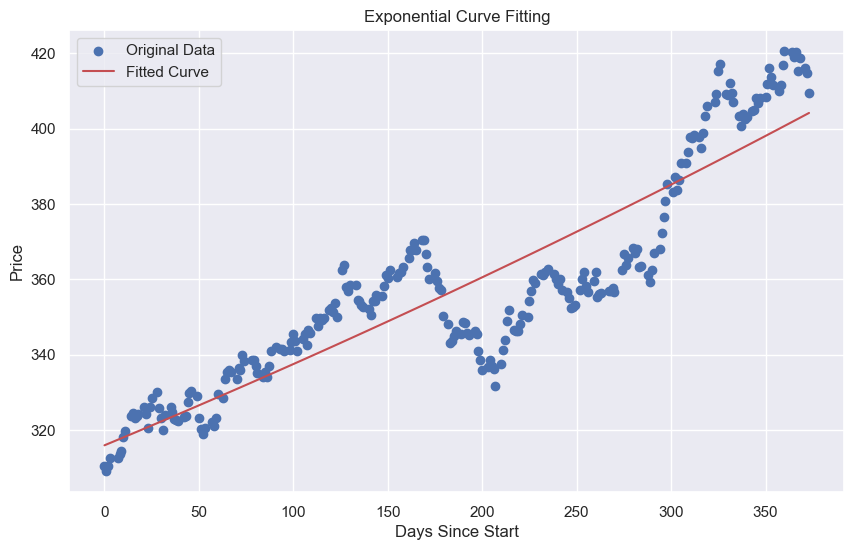

In [20]:
df_sub = df_brk.reset_index()
df_sub = df_sub[df_sub['Date']>=pd.to_datetime('2023-04-01')]
df_sub['days_since_start'] = (df_sub['Date'] - df_sub['Date'].min()).dt.days

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' and contains columns 'days_since_start' and 'Close'

# Define the exponential function
def exponential_func(x, a, b):
    return a * 10**(b * x)

# Initial guess for parameters
initial_guess = (df_sub.head(1)['Close'].unique()[0], np.log10(df_sub.tail(1)['Close'].unique()[0] / df_sub.head(1)['Close'].unique()[0])/df_sub.tail(1)['days_since_start'].unique()[0])  # You might need to adjust these initial values based on your data

# Fit the curve
popt, pcov = curve_fit(exponential_func, df_sub['days_since_start'], df_sub['Close'], p0=initial_guess)

a_fit, b_fit = popt
print(a_fit, b_fit)
print('Final price extracted:',exponential_func(df_sub.tail(1)['days_since_start'].unique()[0],a_fit, b_fit))

# Generate the fitted curve
days_range = np.linspace(df_sub['days_since_start'].min(), df_sub['days_since_start'].max(), 100)
fitted_curve = exponential_func(days_range, *popt)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(df_sub['days_since_start'], df_sub['Close'], label='Original Data')
plt.plot(days_range, fitted_curve, 'r-', label='Fitted Curve')
plt.xlabel('Days Since Start')
plt.ylabel('Price')
plt.title('Exponential Curve Fitting')
plt.legend()
plt.grid(True)
plt.show()
